In [1]:
import os
from collections import Counter

from pygam import LinearGAM, s, f
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

/tmp/ipykernel_94836/2151738973.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.__version__

'2.2.0'

In [3]:
import matplotlib

In [4]:
import upsetplot

In [5]:
from upsetplot import plot, from_memberships, UpSet

In [6]:
plt.rcParams["font.family"] = "Arial Narrow"

# Load PCHiC data

In [7]:
ddir = "../../data/ComplementaryData/PCHiC/"

In [8]:
samples = {
    "0h" : {
        "path" : "DMSO_WT_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": (253 / 256, 231 / 256,  36 / 256, 1),
    },
    "1h" : {
        "path" : "Nutlin1h_WT_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": ( 54 / 256, 181 / 256, 120 / 256, 1),
    },
    "1h-degron" : {
        "path" : "Nutlin1h_KD_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": ( 184 / 256, 112 / 256, 112 / 256, 1),
    },
    "10h" : {
        "path" : "Nutlin10h_WT_merged_recalibrated2WTDMSO_cutoff_5.ibed",
        "color": ( 66 / 256,  54 / 256, 126 / 256, 1),
    },
}

In [9]:
datas = {}
for s in samples:
    data = pd.read_csv(os.path.join(ddir, samples[s]["path"]), sep="\t", low_memory=False,
                      names=[
                          'bait_chr', 'bait_start',	'bait_end',	'bait_name', 'otherEnd_chr', 
                          'otherEnd_start', 'otherEnd_end', 'otherEnd_name', 'N_reads', 'score'
                      ])
    data.drop_duplicates(inplace=True)
    datas[s] = data[['bait_chr', 'bait_start', 'bait_end', 'otherEnd_chr', 'otherEnd_start', 'otherEnd_end']]

In [10]:
for t in datas:
    datas[t]['left_start' ] = datas[t][['bait_start', 'otherEnd_start']].min(axis=1)
    datas[t]['left_end'   ] = datas[t][['bait_end'  , 'otherEnd_end'  ]].min(axis=1)
    datas[t]['right_start'] = datas[t][['bait_start', 'otherEnd_start']].max(axis=1)
    datas[t]['right_end'  ] = datas[t][['bait_end'  , 'otherEnd_end'  ]].max(axis=1)
    datas[t]['left_chrom' ] = datas[t]['bait_chr']
    datas[t]['right_chrom'] = datas[t]['bait_chr']    
    datas[t].loc[datas[t]['bait_start'] > datas[t]['otherEnd_start'], 'left_chrom'] = datas[t].loc[datas[t]['bait_start'] > datas[t]['otherEnd_start'], 'otherEnd_chr']
    datas[t].loc[datas[t]['bait_start'] < datas[t]['otherEnd_start'], 'right_chrom'] = datas[t].loc[datas[t]['bait_start'] < datas[t]['otherEnd_start'], 'otherEnd_chr']
    datas[t] = datas[t][['left_chrom', 'left_start', 'left_end', 
                         'right_chrom', 'right_start', 'right_end']]
    datas[t].drop_duplicates(inplace=True)

/tmp/ipykernel_94836/1582665655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[t]['left_start' ] = datas[t][['bait_start', 'otherEnd_start']].min(axis=1)
/tmp/ipykernel_94836/1582665655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[t]['left_end'   ] = datas[t][['bait_end'  , 'otherEnd_end'  ]].min(axis=1)
/tmp/ipykernel_94836/1582665655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [11]:
times = ['0h', '1h','10h']

In [12]:
t1, t2 = '1h', '10h'

In [13]:
wt = [t1, t2]
others = [t for t in times if t not in wt]
df_all = datas[t1].merge(datas[t2].drop_duplicates(), how='left', indicator=True)
df_all = df_all[df_all['_merge'] == 'left_only'][df_all.columns[:-1]]
for t3 in others:
    df_all = df_all.merge(datas[t3].drop_duplicates(), how='left', indicator=True)
    df_all = df_all[df_all['_merge'] == 'left_only'][df_all.columns[:-1]]

# Intersection of datasets

In [15]:
labels = []
intersections = []
for n, t1 in enumerate(times, 1):
    for t2 in times[n:]:
        labels.append([t1, t2])
        wt = [t1, t2]
        others = [t for t in times if t not in wt]
        df_all = datas[t1].merge(datas[t2].drop_duplicates(), how='left', indicator=True)
        df_all = df_all[df_all['_merge'] == 'both'][df_all.columns[:-1]]
        for t3 in others:
            df_all = df_all.merge(datas[t3].drop_duplicates(), how='left', indicator=True)
            df_all = df_all[df_all['_merge'] == 'left_only'][df_all.columns[:-1]]        
        maintained = len(df_all)
        intersections.append(maintained)

labels.append(['10h', '0h', '1h'])
df_all = datas['0h'].merge(datas['1h'].drop_duplicates(), how='outer', indicator=True)
df_all = df_all[df_all['_merge']=='both'][datas['10h'].columns.to_list()]
df_all = df_all.merge(datas['10h'].drop_duplicates(), how='outer', indicator=True)
intersections.append(len(df_all[df_all['_merge']=='both']))
for n, t1 in enumerate(times[::-1], 1):
    labels.append([t1])
    wt = [t1]
    others = [t for t in times if t not in wt]
    df_all = datas[t1].copy()
    for t3 in others:
        df_all = df_all.merge(datas[t3].drop_duplicates(), how='left', indicator=True)
        df_all = df_all[df_all['_merge'] == 'left_only'][df_all.columns[:-1]]
    intersections.append(len(df_all))

In [16]:
labels = [[f"Nut{l}" for l in ll]for ll in labels]

In [17]:
example = from_memberships(labels, data=intersections)

/home/fransua/.miniconda3/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


In [18]:
example = example.reorder_levels([f"Nut{l}" for l in times])

In [19]:
example

Nut0h  Nut1h  Nut10h
True   True   False      8060
       False  True      24470
False  True   True      11571
True   True   True      30472
False  False  True      34563
       True   False     37057
True   False  False     34689
dtype: int64

/home/fransua/.miniconda3/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/fransua/.miniconda3/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

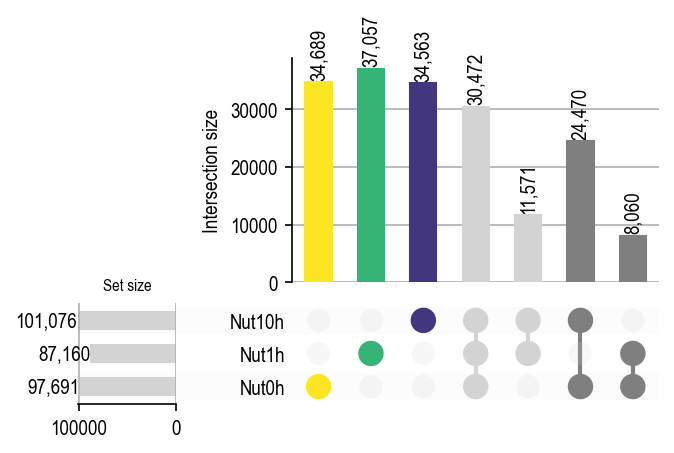

In [22]:
upset = UpSet(example, show_counts='{:,}', sort_by="-input", sort_categories_by='input',
              orientation="horizontal", facecolor='lightgrey')
upset.style_subsets(present=['Nut0h', 'Nut1h'], absent=['Nut10h'], facecolor='tab:grey')
upset.style_subsets(present=['Nut0h', 'Nut10h'], absent=['Nut1h'], facecolor='tab:grey')
upset.style_subsets(present=['Nut0h' ], absent=['Nut1h', 'Nut10h'], facecolor=samples['0h' ]['color'])
upset.style_subsets(present=['Nut1h' ], absent=['Nut0h', 'Nut10h'], facecolor=samples['1h' ]['color'])
upset.style_subsets(present=['Nut10h'], absent=['Nut1h', 'Nut0h' ], facecolor=samples['10h']['color'])
# upset._facecolor = [samples['0h' ]['color'], samples['1h' ]['color'], samples['10h' ]['color']]
axes = upset.plot()
ax_inter = axes['intersections']
for t in ax_inter.get_children():
    if isinstance(t, matplotlib.text.Text) and t.get_text() != '':
        t.set_rotation(90)
ax_totals = axes['totals']
ax_totals.set_title('Set size', size=8)
# ax_totals.remove()
fig = plt.gcf()
fig.set_size_inches(5, 3)
fig.set_dpi(150)

## Including degron (non-cummulative upset plot)

In [25]:
times = ['0h', '1h', '10h', '1h-degron']

In [26]:
labels = []
intersections = []
for n, t1 in enumerate(times, 1):
    labels.append([t1])
    intersections.append(len(datas[t1]))

for n, t1 in enumerate(times, 1):
    for t2 in times[n:]:
        labels.append([t1, t2])
        df_all = datas[t1].merge(datas[t2].drop_duplicates(), how='outer', indicator=True)
        maintained = len(df_all[df_all['_merge']=='both'])
        lost = len(df_all[df_all['_merge']=='left_only'])
        gained = len(df_all[df_all['_merge']=='right_only'])
        intersections.append(maintained)
labels.append(['0h', '1h', '10h'])
df_all = datas['0h'].merge(datas['1h'].drop_duplicates(), how='outer', indicator=True)
df_all = df_all[df_all['_merge']=='both'][datas['10h'].columns.to_list()]
df_all = df_all.merge(datas['10h'].drop_duplicates(), how='outer', indicator=True)
intersections.append(len(df_all[df_all['_merge']=='both']))

labels.append(['0h', '1h', '10h', '1h-degron'])
df_all = df_all[df_all['_merge']=='both'][datas['10h'].columns.to_list()]
df_all = df_all.merge(datas['1h-degron'].drop_duplicates(), how='outer', indicator=True)
intersections.append(len(df_all[df_all['_merge']=='both']))

In [27]:
example = from_memberships(labels, data=intersections)

/home/fransua/.miniconda3/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


In [28]:
example = example.reorder_levels(times)

/home/fransua/.miniconda3/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/fransua/.miniconda3/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

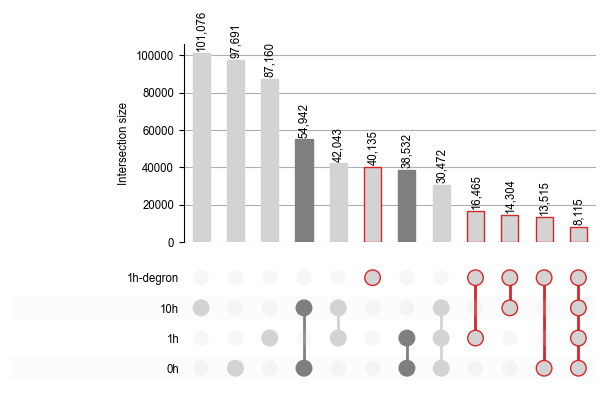

In [29]:
upset = UpSet(example, show_counts='{:,}', sort_categories_by='input',
              sort_by="cardinality", orientation="horizontal", facecolor='lightgrey')
upset.style_subsets(present=['0h', '1h'], absent=['10h'], facecolor='tab:grey')
upset.style_subsets(present=['0h', '10h'], absent=['1h'], facecolor='tab:grey')
upset.style_subsets(present=['1h-degron'], edgecolor='tab:red')
axes = upset.plot()
ax_inter = axes['intersections']
for t in ax_inter.get_children():
    if isinstance(t, matplotlib.text.Text) and t.get_text() != '':
        t.set_rotation(90)
ax_totals = axes['totals']
ax_totals.remove()
fig = plt.gcf()
fig.set_dpi(100)

# Interaction decay with genomic distance

In [40]:
reso = 10_000

vals = {}
for s in samples:
    data = pd.read_csv(os.path.join(ddir, samples[s]["path"]), sep="\t", low_memory=False,
                      names=[
                          'bait_chr', 'bait_start',	'bait_end',	'bait_name', 'otherEnd_chr', 
                          'otherEnd_start', 'otherEnd_end', 'otherEnd_name', 'N_reads', 'score'
                      ])
    data = data[data["bait_chr"] == data["otherEnd_chr"]]
    data["d1"] = abs(data["bait_end"]  - data["otherEnd_start"])
    data["d2"] = abs(data["bait_start"]  - data["otherEnd_end"])
    x = data[["d1", "d2"]].min(axis=1).to_numpy(dtype=int) // reso
    x = Counter(x)
    factor = sum(x.values()) / 100_000
#     factor = 1
    vals[s] = [x.get(v, 0) / factor for v in range(20_000 // reso, 1_100_000 // reso + 1)]
    vals[s].append(sum(x[v] for v in x if v > 1_100_000 // reso))

In [42]:
samples.keys()

dict_keys(['0h', '1h', '1h-degron', '10h'])

In [44]:
df = pd.DataFrame.from_dict(vals)

In [45]:
df = df

In [46]:
df[None] = [f"{i * 10}-{(i + 1) * 10}kb" for i in range(len(df))]

In [47]:
df.drop(df.tail(n).index,inplace=True)

In [48]:
df = df.set_index(None)

In [54]:
# df.to_excel("pchic_di-tags_per_distance-range.xls")  # save it to excel

In [51]:
times = ['0h', '1h', '10h']

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


14.405056375600074 0.9986550079651926
19.383520719369866 0.998658650328831
19.383520719369866 0.9985751767190827


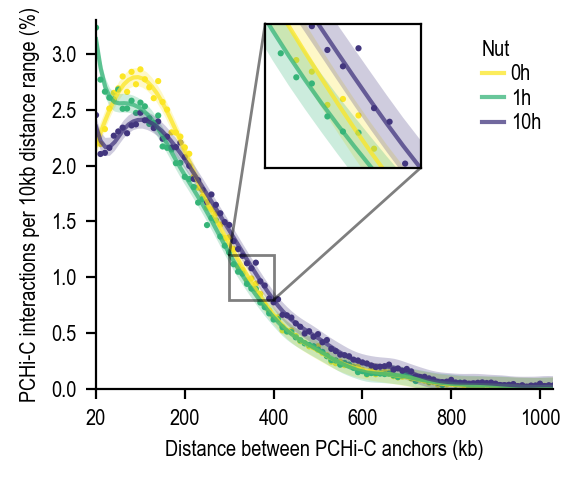

In [52]:
plt.figure(figsize=(3, 2.5), dpi=200)
ax = plt.subplot()
zoom = True
degron = False
if zoom:
    axins = ax.inset_axes([0.37, 0.6, 0.34, 0.39])
for w in (samples if degron else times):
    y = vals[w][:-5]
    X = np.asarray([[v,] for v in range(len(y))])
    gam = LinearGAM().gridsearch(X, y)
    XX = gam.generate_X_grid(term=0)
    ax.plot(XX, gam.predict(XX), '-', label=f"{w}", color=samples[w]["color"], alpha=0.75)
    if zoom:
        axins.plot(XX, gam.predict(XX), '-', label=f"{w}", color=samples[w]["color"], alpha=0.75)
    y0, y1 = list(zip(*gam.prediction_intervals(XX, width=.95)))
    ax.fill_between([v[0] for v in XX], y0, y1, color=samples[w]["color"], alpha=0.25, ec='none')
    if zoom:
        axins.fill_between([v[0] for v in XX], y0, y1, color=samples[w]["color"], alpha=0.25, ec='none')
    ax.scatter(X, y, facecolor=samples[w]["color"], alpha=1, edgecolors='none', s=5)
    if zoom:
        axins.scatter(X, y, facecolor=samples[w]["color"], alpha=1, edgecolors='none', s=5)
    print(gam.statistics_['edof'], gam.statistics_['pseudo_r2']['explained_deviance'])
# ax.collections[-2].set_label('95% prediction')
# ax.collections[-1].set_label('Observed percentage')


ax.set_xlim(0, len(X)-2)
ax.set_ylim(0, 3300)
leg = ax.legend(frameon=False, bbox_to_anchor=(0.8, 1), loc='upper left', handlelength=1, ncol=1, 
                fontsize=8, title="Nut", labelspacing = 0.2, handletextpad=0.3)
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize="8")

if zoom:
    axins.set_xlim(300_000 / reso, 400_000 / reso)
    axins.set_ylim(800, 1200)
    axins.set_xticks([])
    axins.set_yticks([])
    ax.indicate_inset_zoom(axins, edgecolor="black")

# leg.legendHandles[-1].set_color('grey')
# leg.legendHandles[-2].set_color('grey')

xs = [0] + list(range(20, len(X) + 2, 20))
ys = [v for v in range(0, 3500, 500)]
ax.set_xticks(xs)
ax.set_xticklabels([f"{((v if v else 2) * reso) // 1_000}".replace("1000kb", "1Mb") for v in xs], size=8)

ax.set_yticks(ys)
ax.set_yticklabels([f"{v / 1_000:.1f}" for v in ys], size=8)
ax.set_xlabel("Distance between PCHi-C anchors (kb)", size=8)
ax.set_ylabel("PCHi-C interactions per 10kb distance range (%)", size=8)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
# plt.savefig(f"fig4D_10kb_{'' if zoom else 'no'}zoom_{'' if degron else 'no'}degron.pdf", dpi=300)

In [53]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.3835
Link Function:                     IdentityLink Log Likelihood:                                  -852.8567
Number of Samples:                          105 AIC:                                             1746.4804
                                                AICc:                                            1756.9059
                                                GCV:                                             1992.4834
                                                Scale:                                           1343.7272
                                                Pseudo R-Squared:                                   0.9986
Feature Function                  Lam

/tmp/ipykernel_94836/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
